<a href="https://colab.research.google.com/github/JI411/svoice/blob/google_colab/drz_facebookresearch_svoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Разделение спикеров в Google Colab с facebookresearch/svoice

* Вычислительных ресурсов google colab не хватит на обучение модели для приемлимых (хотя бы на слух) результатов, но можно посравнивать loss и SI-SNRi на небольших выборках при разных гиперпараметрах.
* Если аудио длятся дольше пяти часов, то они, скорее всего, не влезут в память VM.

#### Ввод данных

* PATH_TO_ZIP - путь до zip архива на гугл-диске. В архиве лежит единственная папка, содержащая тренировочные стерео wav.
* PATH_TO_WAV_FOLDER - директория, в которую будут положены папки mix, s1, s2 и результаты экспериментов, там же при обработке лежат все wav
* N - используется только каждая N-я запись из архива

In [ ]:
PATH_TO_ZIP = '/content/drive/MyDrive/Colab_Notebooks/data/svoice/example/example.zip'
PATH_TO_WAV_FOLDER = '/content/drive/MyDrive/Colab_Notebooks/data/svoice/example_data'
N = 1

#### Проверка GPU, установка и импорт библиотек, подключение гугл-диска

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
assert GPU.getGPUs()[0].memoryFree > 12000, "надо закрыть другие сессии и сделать перезапуск коллаба, повторять пока он не перестанет жадничать"

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=e6d8b3277251137271ec3960415a1e3675821b2ead9e217ff7df23739faae0e9
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
!git clone https://github.com/JI411/svoice
!pip install -r /content/svoice/requirements.txt
!pip install pydub

In [ ]:
import os
import json
import zipfile
import shutil
import random
import IPython.display as ipd
from pydub import AudioSegment
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Распаковка архива, подготовка данных

In [ ]:
if not os.path.exists(PATH_TO_WAV_FOLDER):
  os.mkdir(PATH_TO_WAV_FOLDER)
os.mkdir(PATH_TO_WAV_FOLDER + '/mix')
os.mkdir(PATH_TO_WAV_FOLDER + '/s1')
os.mkdir(PATH_TO_WAV_FOLDER + '/s2')

zfile = zipfile.ZipFile(file=PATH_TO_ZIP)
zfile.extractall(PATH_TO_WAV_FOLDER + '/tmp')

In [ ]:
def wav_paths(path):
  wav_path = []
  folder = os.listdir(path=path)
  for file in folder :
      if file.endswith("wav"):
        wav_path.append(file)
  return wav_path

In [ ]:
# создаем аудио и экономим время на создание json, выполняя эти процессы одновременно
# такая структура вложенных папок необходима для предотвращения I/O error при длине аудио более часа
# аудио нарезаются чтобы влезть в память
wav_names = wav_paths(PATH_TO_WAV_FOLDER + '/tmp')[::N]
all_len = 0
start = datetime.now()
json_mix = []
json_s1 = []
json_s2 = []
for i, audio in enumerate(sorted(wav_names)):
  random_len = random.randint(8, 12) * 500
  all_output = AudioSegment.from_file(PATH_TO_WAV_FOLDER + '/tmp/' + audio, format="wav")[::random_len]
  
  for j, output in enumerate(all_output):
    all_len += len(output)
    
    sound1, sound2 = output.split_to_mono()
    output = output.set_channels(1)
 
    fr_out = int(output.frame_count() * output.channels)
    fr_s1 = int(sound1.frame_count() * sound1.channels)
    fr_s2 = int(sound2.frame_count() * sound2.channels)
 
    if not (fr_out == fr_s1 == fr_s2):
      min_len = min([len(sound1), len(sound2)])
      tmp = AudioSegment.silent(duration = min_len - 1)
      output = tmp.overlay(output)
      sound1 = tmp.overlay(sound1)
      sound2 = tmp.overlay(sound2)
    
 
    for root in ('/mix/', '/s1/', '/s2/'):
      audio_name = audio[audio.rfind('/') + 1:]
      segment_name = audio_name + '_'+ str(j)
      new_path = PATH_TO_WAV_FOLDER + root + 'group_' + str(i // 2000) + '/' + str(j // 50) + '/' + audio_name  + '/' + segment_name + '.wav'
      new_fold = new_path[:new_path.rfind('/')]
      if not os.path.exists(new_fold):
        os.makedirs(new_fold)
      if root == '/mix/':
        json_mix.append([new_path, fr_out])
        output.export(new_path, format="wav")
      elif root == '/s1/':
        json_s1.append([new_path, fr_s1])
        sound1.export(new_path, format="wav")
      else:
        json_s2.append([new_path, fr_s2])
        sound2.export(new_path, format="wav")
    
  if i % 500 == 0:
    print(i, '--->' , datetime.now() - start)
      
    

with open(PATH_TO_WAV_FOLDER + '/mix.json', "w") as write_file:
  json.dump(json_mix, write_file, indent=4)
  print('',file=write_file)
 
with open(PATH_TO_WAV_FOLDER + '/s1.json', "w") as write_file:
  json.dump(json_s1, write_file, indent=4)
  print('',file=write_file)

with open(PATH_TO_WAV_FOLDER + '/s2.json', "w") as write_file:
  json.dump(json_s2, write_file, indent=4)
  print('',file=write_file)

all_len = all_len / 1000 / 60 / 60
print(f'Итого аудио: {all_len / 1000 / 60 / 60} часов')


0 ---> 0:00:00.614473
Итого аудио: 3.4817129629629624e-08 часов


In [ ]:
shutil.rmtree(PATH_TO_WAV_FOLDER + '/tmp')
shutil.rmtree('/content/sample_data')
os.makedirs('/content/svoice/egs/debug/tr')
shutil.copy(PATH_TO_WAV_FOLDER + '/mix.json', '/content/svoice/egs/debug/tr')
shutil.copy(PATH_TO_WAV_FOLDER + '/s1.json', '/content/svoice/egs/debug/tr')
shutil.copy(PATH_TO_WAV_FOLDER + '/s2.json', '/content/svoice/egs/debug/tr')

'/content/svoice/egs/debug/tr/s2.json'

#### Запуск train.py, отрисовка графиков и сохранение на диск

In [ ]:
%cd /content/svoice
!python3 train.py epochs=30 swave.L=16 lr=0.001 swave.input_normalize=True

/content/svoice
[2021-03-21 04:50:49,399][__main__][INFO] - For logs, checkpoints and samples check /content/svoice/outputs/exp_epochs=30,lr=0.001,swave.L=16,swave.input_normalize=True
[2021-03-21 04:50:51,157][__main__][INFO] - Running on host fc98c3e0faa5
[2021-03-21 04:50:54,160][svoice.solver][INFO] - ----------------------------------------------------------------------
[2021-03-21 04:50:54,160][svoice.solver][INFO] - Training...
[W TensorIterator.cpp:918] Warning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (function operator())
[2021-03-21 04:51:01,111][svoice.solver][INFO] - Train | Epoch 1 | 7/38 | 1.2 it/sec | Loss 14.77529
[2021-03-21 04:51:07,735][svoice.solver][INFO] - Train | Epoch 1 | 14/38 | 1.1 it/sec | Loss 10.65026
[2021-03-21 04:51:14,421][svoice.solver][INFO] - Train | Epoch 1 | 21/38 | 1.1 it/sec | Loss 8.87374
[2021-03-21 04:51:21,131][svoice.sol

In [ ]:
# указать параметры, с которыми запускается train.py
PARAMS = 'epochs=30 swave.L=16 lr=0.001 swave.input_normalize=True' 

In [ ]:
params = ','.join(sorted(PARAMS.split()))

file_name = '/content/svoice/outputs/exp_' + params + '/trainer.txt'
shutil.copy('/content/svoice/outputs/exp_' + params + '/trainer.log', file_name)
with open(file_name) as f:
    f = f.readlines()
 
start_time = [int(i) for i in f[0][f[0].find(' '):f[0].find(',')].split(':')]
start_time = start_time[0] * 60 * 60 + start_time[1] * 60 + start_time[2]
 
 
data = pd.DataFrame([], columns=['epoch', 'abs_time', 'train', 'valid', 'sisnr'])
f = [s for s in f if 'Overall Summary'  in s]
for i, line in enumerate(f):
    time = line[line.find(' ') + 1:line.find(',')]
    abs_time = [int(i) for i in time.split(':')]
    abs_time = abs_time[0] * 60 * 60 + abs_time[1] * 60 + abs_time[2] - start_time
 
    train = float(line[line.find('Train ') + len('Train ') : line.find(' | Valid')])
    valid  = float(line[line.find('| Valid ') + len('| Valid ') : line.find(' | Best')])
 
    epoch = int(line[line.find('Epoch ') + len('Epoch ') : line.find(' | Train')])
    if 'Sisnr' in line:
      sisnr = float(line[line.find('Sisnr ') + len('Sisnr ') : line.find(' | Pesq')])
    elif i == 0:
      sisnr = np.NaN
    else:
      sisnr = data.loc[i - 1, 'sisnr']
 
      
    data.loc[i] = {'sisnr':sisnr, 'abs_time':abs_time, 'train':train, 'valid':valid, 'epoch' : epoch} 
data.set_index('epoch', inplace=True)
data['sisnr'].fillna(data['sisnr'].min(), inplace=True)
data.to_csv('/content/svoice/outputs/exp_' + params + '/pandas_log.csv')
data.tail(10)

,abs_time,train,valid,sisnr
epoch,,,,
21,1168,-1.89398,-3.91588,3.80037
22,1222,-2.19364,-4.79856,3.80037
23,1275,-2.53814,-5.45905,3.80037
24,1329,-2.55446,-6.37085,3.80037
25,1382,-2.80653,-6.51318,3.80037
26,1436,-3.17362,-7.29180,3.80037
27,1490,-3.29335,-6.30241,3.80037
28,1543,-3.28333,-7.54677,3.80037
29,1597,-3.72834,-7.08760,3.80037


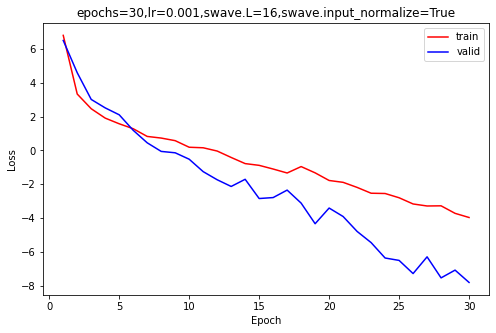

In [ ]:
fig, ax = plt.subplots()
plt.title(params)
plt.xlabel("Epoch")
plt.ylabel("Loss")

ax.plot(data.index, data['train'], label = 'train', color='r')
ax.plot(data.index, data['valid'], label = 'valid', color='b')

ax.legend()
fig.set_figheight(5)
fig.set_figwidth(8)
fig.savefig('/content/svoice/outputs/exp_' + params + '/loss.png')

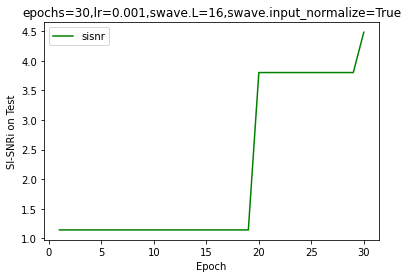

In [ ]:
plt.plot(data.index, data['sisnr'], label = 'sisnr', color='g')
plt.title(params)
plt.ylabel("SI-SNRi on Test")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('/content/svoice/outputs/exp_' + params + '/sisnr.png')

In [ ]:
out_path = PATH_TO_WAV_FOLDER + '/exp_' + params + '_expnum_'

i = 0
while os.path.exists(out_path + str(i)):
  i += 1

shutil.copytree('/content/svoice/outputs/exp_' + params, out_path + str(i))

'/content/drive/MyDrive/Colab_Notebooks/data/svoice/example_data/exp_epochs=30,lr=0.001,swave.L=16,swave.input_normalize=True_expnum_0'

#### Разделение на новых данных

In [ ]:
# !python -m svoice.separate <path to the model> <path to store the separated files> --mix_dir=<path to the dir with the mixture files>
#### тест
%cd /content/svoice
os.mkdir('/content/test_out')
!python -m svoice.separate '/content/svoice/outputs/exp_epochs=30,lr=0.001,swave.L=16,swave.input_normalize=True/checkpoint.th' '/content/test_out/' --mix_dir=''

In [ ]:
# осторожно, посторонние шумы могут быть очень громкими
for f in os.listdir('/content/test_out/'):
  if 'mix' not in f:
    ipd.display(ipd.Audio('/content/test_out/' + f))